# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
 of the same name which is soon to be submitted. In particular, this notebook includes code used to generate 
 all the figures included within that paper. 

## Setting up the codes

First, we load in the necesarry Python modules. The module SLmod.py contains much of the code needed for the calculations.

In [2]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations below L = 256 is a sensible value. The maximum possible is L = 1024, this being set by the Love numbers that have been pre-calculated and are read in below. The code also works out the ocean function from sea level and ice thickness. Note that the defintion of the ocean function calculation does not account for isolated regions below sea level. As a result, the Caspian sea is regarded as part of the oceans. This could be readily fixed, but the effects are small and are not important for our present purposes.

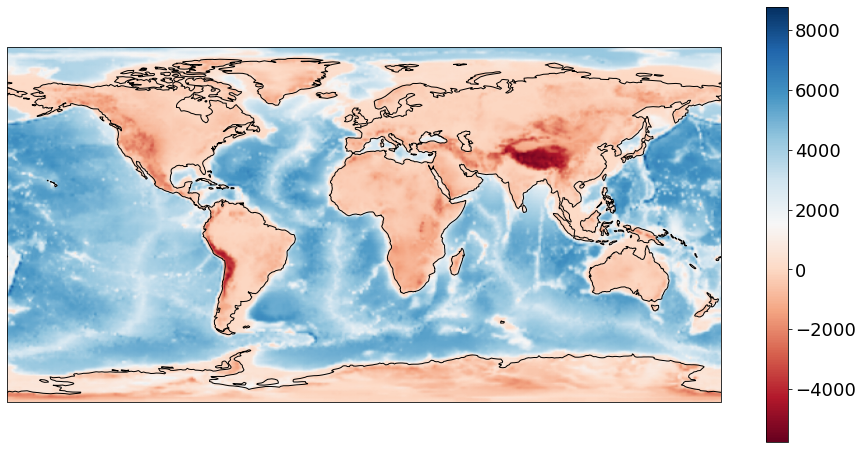

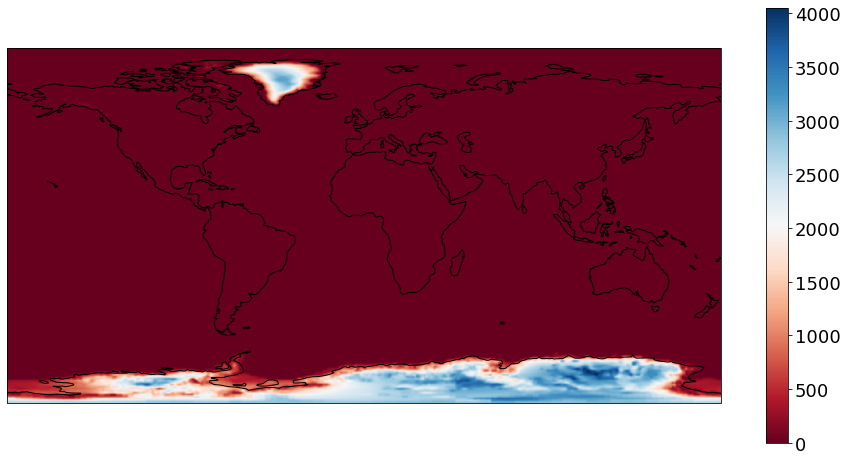

fraction of surface which is ocean =  0.712960233719624


In [3]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0)
SL.plot(ice0)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*SL.b**2
print('fraction of surface which is ocean = ',A/A_earth)

## Solving the sea level equation to make a synthetic data set

Our first task is to solve the sea level equation for a given change to the ice thickness. For 
definiteness, we will melt a uniform fraction from the Greenland ice sheet (strictly, the code considers
all northern hemisphere ice within the model as this is easiest to implement). Writing $I_{0}$ for 
the initial thickness, and $I$ for the change, we assume that
\begin{equation}
I = -0.01\,I.
\end{equation}
Such a choice is arbitrary and the codes below do not depend upon it. 

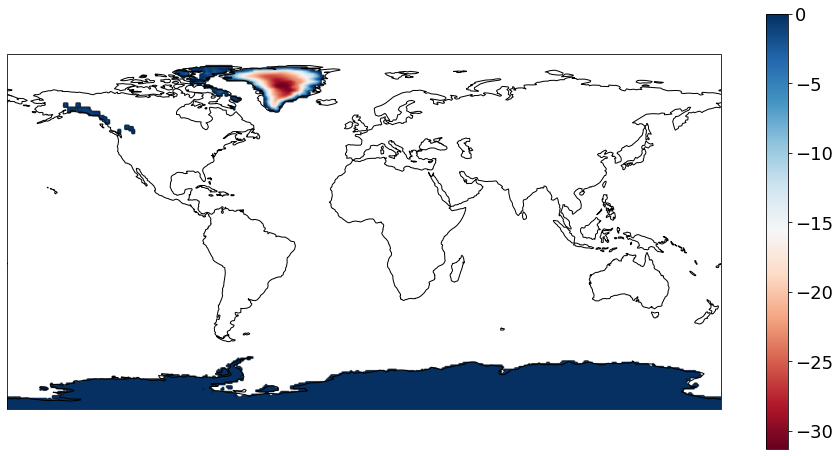

In [4]:
# set the change in ice thickness
ice = -0.01*SL.zero_southern_hemisphere(ice0)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*ice)

Using the change in ice thickness, we can define the corresponding direct load
\begin{equation}
\zeta = \rho_{i} \,(1-C) \, I, 
\end{equation}
with $\rho_{i}$ the density of ice. This load is then passed to a function for solving the sea level equation to return the change in sea level, $SL$, the vertical displacement, $u$, the change in surface gravitational potential, $\phi$, the perturbation to the rotation vector $\omega$, and the change in centrifugal potential, $\psi$. Note that within these calculations the rotational perturbation is assumed to lie entirely within the plane orthogonal to the reference rotation axis. This is done because the component along the rotation axis is signigicantly smaller. However, the theoretical results to be demonstrated do not depend on such an approximation, and remain valid in either case.

iteration =  1 relative change =  0.020752304973636306
iteration =  2 relative change =  0.0025119189708964445
iteration =  3 relative change =  0.00042090945934040997
iteration =  4 relative change =  8.310105021664877e-05
iteration =  5 relative change =  1.8083394636435607e-05
iteration =  6 relative change =  4.2436704066281505e-06
iteration =  7 relative change =  1.0687214219102285e-06
iteration =  8 relative change =  2.8727975155626794e-07


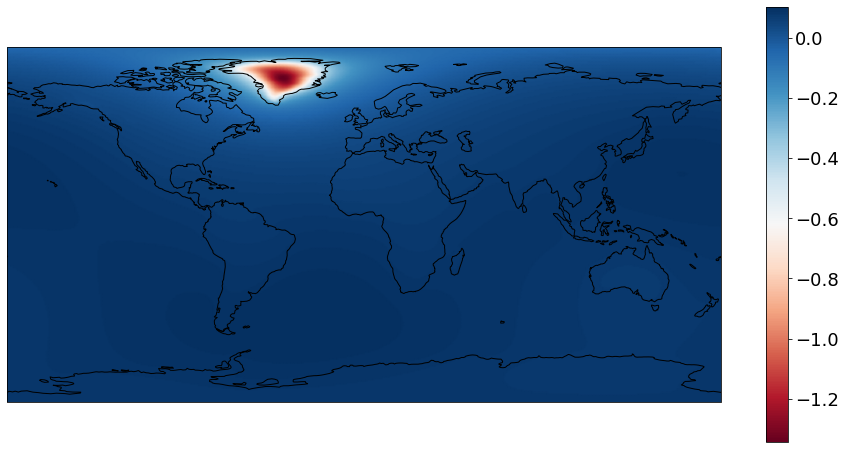

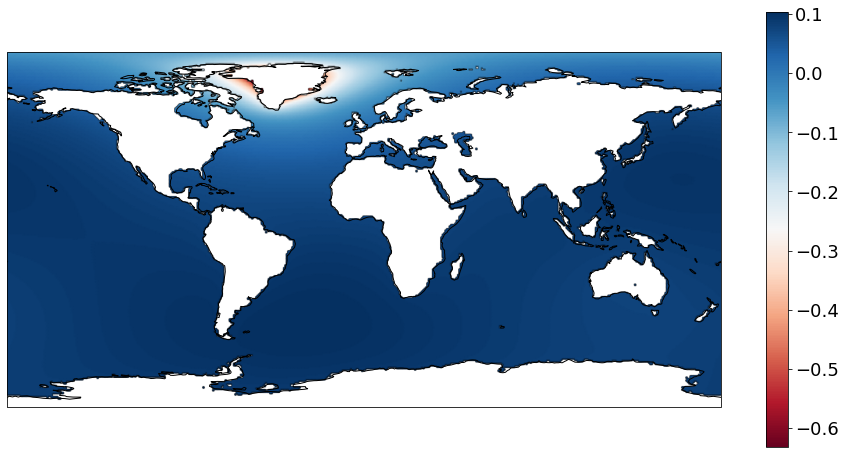

In [5]:
# set the direct load
zeta   = SL.rhoi*(1-C)*ice

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(sl)

# plot the result within the oceans only
ocean_mask = SL.ocean_mask(sl0,ice0)
SL.plot(ocean_mask*sl)


## Testing the simplest form of the reciprocity theorem

We start by verifying the relation
\begin{equation}
    \int_{\partial M} SL^{\dagger} \, \zeta \, \mathrm{d} S = \int_{\partial M} SL \, \zeta^{\dagger} \, \mathrm{d} S. 
\end{equation}
Here $SL$ is the sea level change due to a direct load, $\zeta$, while $SL^{\dagger}$ is the 
corresponding field due to $\zeta^{\dagger}$. For $(SL,\zeta)$, we can use the values just determined
through melting of Greenland. For the "adjoint" quantities $(SL^{\dagger},\zeta^{\dagger})$ we can choose freely, with, in particular, the direct load $\zeta^{\dagger}$ not needing to correspond to 
an change in ice thickness. As a starting point, however, let's suppose that the adjoint problem corresponds to melting some fraction of the ice in the southern hemisphere. This is done below, and having solved the adjoint problem we compute either side of the reciprocity theorem and see that they agree to the precision of the calculations (relative error around $1\times 10^{-6}$ as set by parameter ep in SLmod.py).

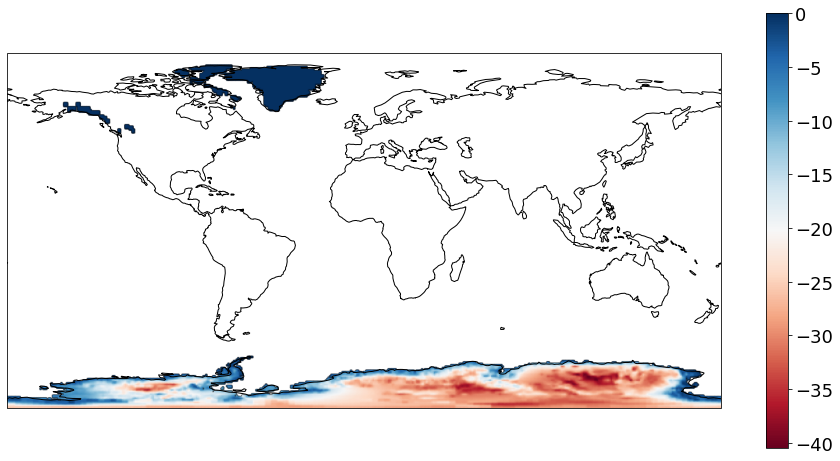

iteration =  1 relative change =  0.04075810109395526
iteration =  2 relative change =  0.005398114708201404
iteration =  3 relative change =  0.0009190474454995303
iteration =  4 relative change =  0.00017555235062886184
iteration =  5 relative change =  3.640102914569564e-05
iteration =  6 relative change =  8.085586721297318e-06
iteration =  7 relative change =  1.91316470496394e-06
iteration =  8 relative change =  4.804426061611512e-07


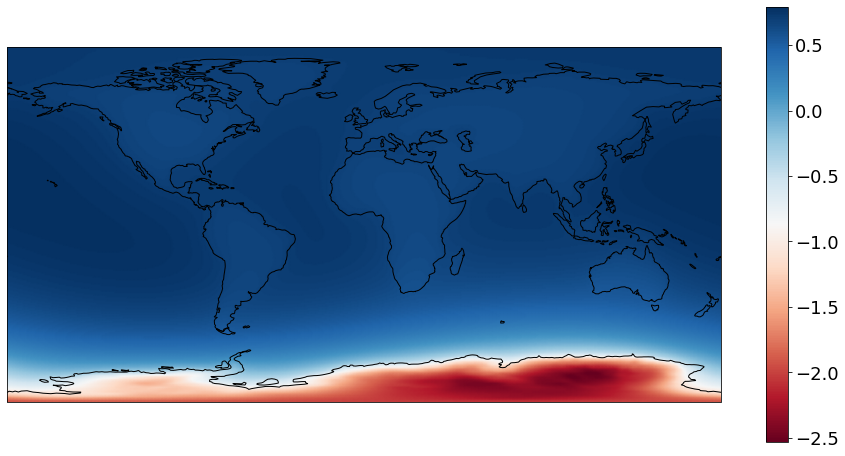

left hand side      =  -1.905794679748681e+16
right hand side     =  -1.9057946797486804e+16
relative difference =  2.09886198261792e-16


In [6]:
# set the direct load
ice_d = -0.01*SL.zero_northern_hemisphere(ice0)
zeta_d = SL.rhoi*(1-C)*ice_d
SL.plot(ice_mask*ice_d)

# solve the fingerprint problem
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d)

# compute the left hand integral
lhs = SL.surface_integral(sl_d*zeta)

# compute the right hand integral
rhs = SL.surface_integral(sl*zeta_d)

# print the values out along with the relative difference
print('left hand side      = ', lhs)
print('right hand side     = ',rhs)
print('relative difference = ', np.abs((lhs-rhs)/lhs))

## Determining the sensitivity kernel for sea level at a given location

If we take the adjoint direct load to be
\begin{equation}
\zeta^{\dagger}(\mathbf{x}) = \delta(\mathbf{x},\mathbf{x}_{0}), 
\end{equation}
then the reciprocity theorem reduces to
\begin{equation}
SL(\mathbf{x}_{0}) = \int_{\partial M} SL^{\dagger} \, \zeta \, \mathrm{d} S, 
\end{equation}
which shows that the function derivative (or sensitivity kernel) of $SL(\mathbf{x}_{0})$
with respect to $\zeta$ is just $SL^{\dagger}$ as calculated from the delta function load.
The code below first solves the fingerprint problem for the point load to obtain $SL^{\dagger}$.

iteration =  1 relative change =  0.007498802295050246
iteration =  2 relative change =  0.000283229313197955
iteration =  3 relative change =  3.583373930837417e-05
iteration =  4 relative change =  7.016853313340049e-06
iteration =  5 relative change =  1.529971132214761e-06
iteration =  6 relative change =  3.5934457306791405e-07


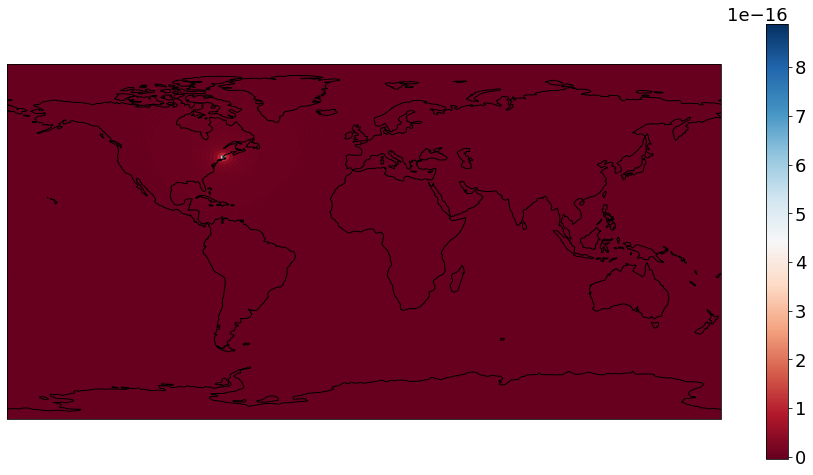

direct sea level value =  0.02832457677426556
left hand side         =  0.028324576774265687
right hand side        =  0.028325699034195885
relative difference    =  3.962141920573222e-05


In [7]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589

# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d)

# set the value of sea level directly from the field 
# note the different convention for longitude in the function called
sl_lm = sl.expand();
sl_direct = pysh.expand.MakeGridPoint(sl_lm.coeffs,lat,lon+180)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ', lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


Recalling that the direct load takes the form $\zeta = \rho_{i} (1-C) I$ within the physical problem, 
we can also express the sea level at the observation point as
\begin{equation}
SL(\mathbf{x}_{0}) = \int_{\partial M} \rho_{i}\, (1-C)\, SL^{\dagger} \, I \, \mathrm{d} S, 
\end{equation}
which shows that the sensitivity kernel with respect to $I$ is given by
\begin{equation}
K =  \rho_{i}\, (1-C)\, SL^{\dagger},
\end{equation}
and this is plotted within the following code with the zero values in the oceans masked out for clarity.


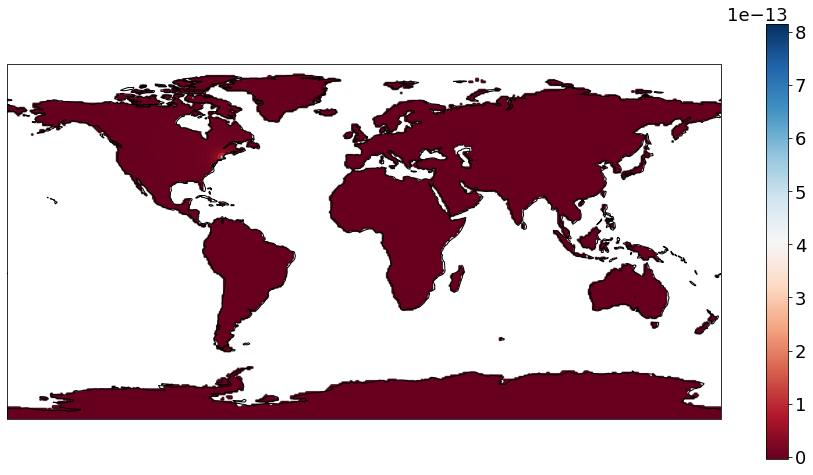

In [8]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K)

An issue here is that this function captures sensitivity to changes in ice thickness at all locations where there *could* be grounded ice. But, of course, we only really care about the sensitivity where there is ice, and hence it is useful to projection this function onto regions where ice is currently found:

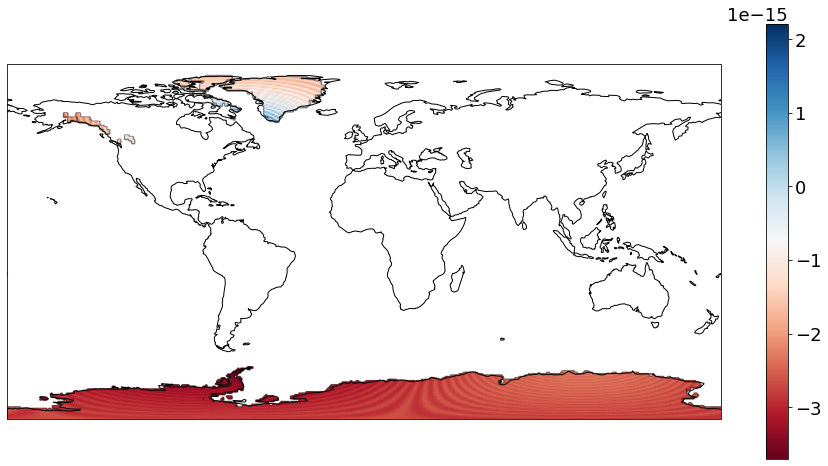

In [9]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)

The issue now is that the kernel is obviously quite ringy, and it is not clear if such behaviour is physically meaningful. What is happening is that the delta load is formed from a truncated spherical harmonic expansion. There is, therefore and errir that is restricted to degrees greater than $L$, and this is what causes the ringing. Within many practical applications, this ringing is of no significance. But for visualisation purposes, it can be removed by smoothing the delta function over a desired length-scale. In practice, this means that instead of measuring sea level at a point, we are averaging it's value over a set distance about the observation point. Because sea level changes calculated for realistic ice loads are quite smooth, such an averaging is a reasonable thing to do. The code below redoes the calculations above to obtain the sensitivity kernel for the ice load, but using a smoothed delta function over a width of one degree about the observation point. 

iteration =  1 relative change =  0.013156459562002653
iteration =  2 relative change =  0.0005963365563466575
iteration =  3 relative change =  7.416563302651798e-05
iteration =  4 relative change =  1.4484953349054696e-05
iteration =  5 relative change =  3.155501269818817e-06
iteration =  6 relative change =  7.406191317725388e-07


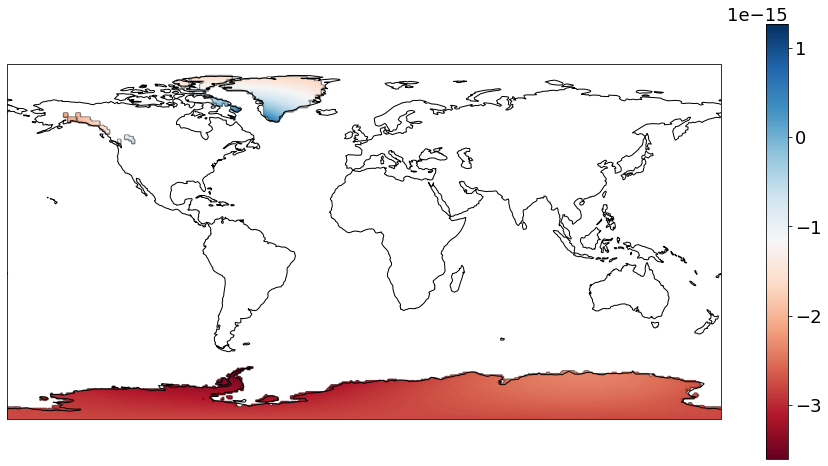

In [10]:
# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)


The form of this sensitivity kernel over Greenland can be compared to the result shown in Fig.1 of Mitrovica *et al.* (2018) for Boston that where obtained using a comparatively costly finite-difference approach. 
With the present method, it is a simple matter to compute such kernels for any desired location. Here, for example, Thessaloniki  which was also considerd by Mitrovica *et al.* (2018)

iteration =  1 relative change =  0.009206639266841867
iteration =  2 relative change =  0.0002972036130504574
iteration =  3 relative change =  3.3897291772051165e-05
iteration =  4 relative change =  7.222269680173318e-06
iteration =  5 relative change =  1.983080694668579e-06
iteration =  6 relative change =  5.740648227293107e-07


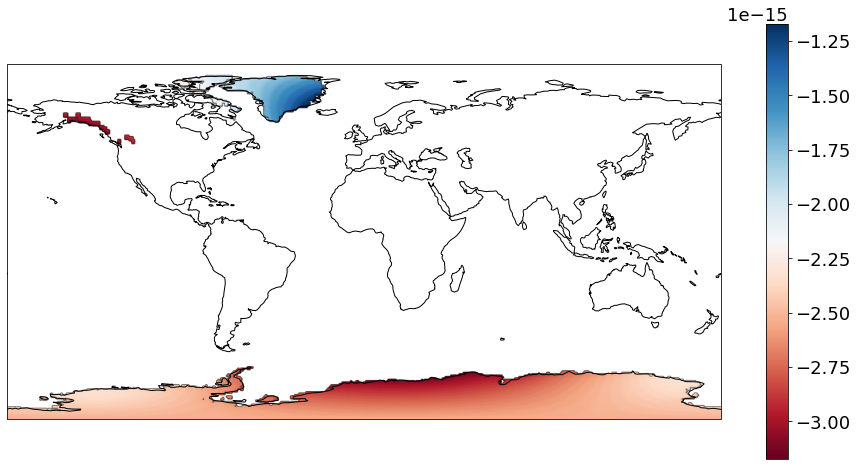

In [11]:
# calculate kernel for Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)

# Checking the generalised form of the reciprocity theorem

To obtain sensitivity kernels for more general observables (e.g. vertical displacements, or sea surface
height changes), it is necessary to consider a generalisation of the fingerprint problem that includes additional non-physical loads. The corresponding reciprocity theorem is given by
\begin{equation}
  \int_{\partial M} SL^{\dagger} \,\zeta \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}\mathbf{u}^{\dagger}\cdot \nabla \Phi + \zeta_{\phi} (\phi^{\dagger}
    + \psi^{\dagger})] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}\cdot \omega^{\dagger} 
    = \int_{\partial M} SL \,\zeta^{\dagger} \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}^{\dagger}\mathbf{u}\cdot \nabla \Phi + \zeta_{\phi}^{\dagger} (\phi
    + \psi)] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}^{\dagger}\cdot \omega. 
\end{equation}
When $SL$ is obtained through the standard fingerprint problem, this identity simplifies to
\begin{equation}
 \int_{\partial M} SL^{\dagger} \,\zeta \,\mathrm{d} S
    = \int_{\partial M} SL \,\zeta^{\dagger} \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}^{\dagger}\mathbf{u}\cdot \nabla \Phi + \zeta_{\phi}^{\dagger} (\phi
    + \psi)] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}^{\dagger}\cdot \omega, 
\end{equation}
which is sufficient to determine the sensitivity kernels for all cases of practical interest. A number of examples are given below, with the validity of the kernel being checked by directly integrating evaluating the observable using the results of the fingerprint calculation for Greenland done above.



### Case 1: Vertical displacement measurement

If the observation point is $\mathbf{x}_{0}$, then the adjoint loads are:
\begin{equation}
\zeta^{\dagger} = 0, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = -\delta(\mathbf{x},\mathbf{x}_{0}), 
\quad \zeta_{\phi}^{\dagger} = 0, \quad \mathbf{k}^{\dagger} = \mathbf{0}.
\end{equation}
The following code implements and checks the results in this case. Note that the point load 
has been smoothed over a degree for plotting.

iteration =  1 relative change =  0.004824476607191903
iteration =  2 relative change =  7.940884654247491e-05
iteration =  3 relative change =  1.853727356884578e-05
iteration =  4 relative change =  4.620800785114988e-06
iteration =  5 relative change =  1.1903515010316172e-06
iteration =  6 relative change =  3.1722351891667645e-07

direct displacement value =  0.021936222589233882
left hand side            =  0.021935257492862098
right hand side           =  0.021936222589233976
relative difference       =  4.399749454465636e-05

iteration =  1 relative change =  0.008350226899544923
iteration =  2 relative change =  0.00018634713400230568
iteration =  3 relative change =  4.2026742115896696e-05
iteration =  4 relative change =  1.0476011402302013e-05
iteration =  5 relative change =  2.698691552573231e-06
iteration =  6 relative change =  7.191874608198654e-07


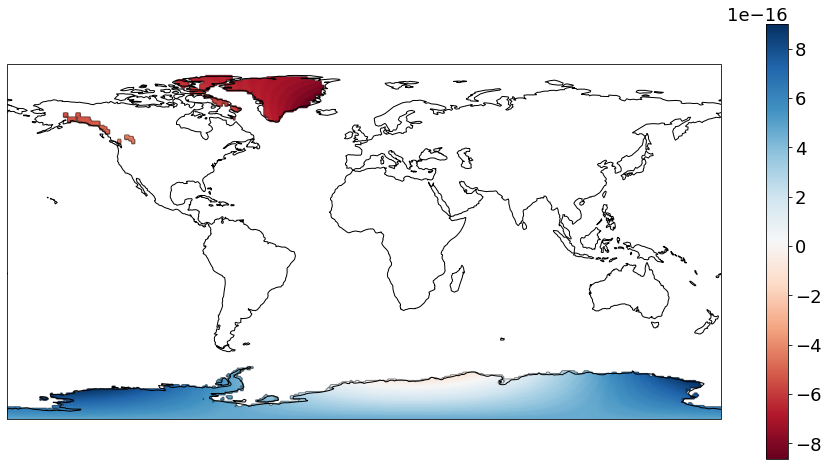

In [12]:
# set the observation point in Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)

### Case 2: gravitational potential coefficient measurement

If the observation we want to measure the $(l,m)$th coefficient for $l \ge 2$ we set
\begin{equation}
\zeta^{\dagger} = 0, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = 0, 
\quad \zeta_{\phi}^{\dagger} = -g Y_{lm}, \quad \mathbf{k}^{\dagger} = \int_{\partial M}\zeta_{\phi}^{\dagger} \, \mathbf{x} \times
    (\Omega \times \mathbf{x}) \,\mathrm{d} S, 
\end{equation}
with $Y_{lm}$ a fully normalised real spherical harmonic. Note that the value of $\mathbf{k}^{\dagger}$
has been set so as to remove the contribution to the right hand side from $\psi$.


iteration =  1 relative change =  0.24619141612822476
iteration =  2 relative change =  0.06041679751869183
iteration =  3 relative change =  0.01501116437972224
iteration =  4 relative change =  0.003806377939649515
iteration =  5 relative change =  0.0009915570987487775
iteration =  6 relative change =  0.00026617923201668084
iteration =  7 relative change =  7.373498099878029e-05
iteration =  8 relative change =  2.1058273362008794e-05
iteration =  9 relative change =  6.183411742172596e-06
iteration =  10 relative change =  1.8595179041871948e-06
iteration =  11 relative change =  5.703714206518092e-07

direct potential value    =  -0.20851223904470642
left hand side            =  -0.20852817919249725
right hand side           =  -0.20851223904470675
relative difference       =  7.64412169723086e-05



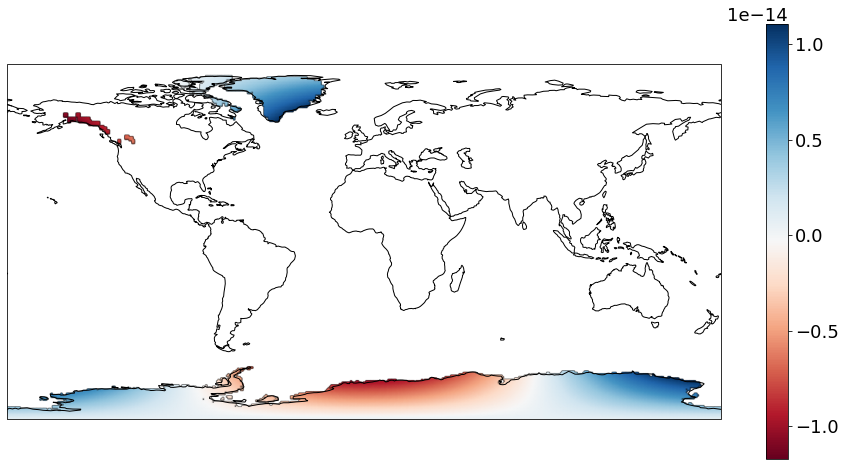

In [22]:
# set the adjoint loads
l = 2
m = 1
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)

## Case 3: Spatial average of sea surface height change

Here we consider the observable
\begin{equation}
J = \frac{1}{A_{obs}}\int_{\partial M_{obs}}  SSH \, \mathrm{d} S, 
\end{equation}
where $SSH$ denotes the sea surface height change as might be observed using satellite altimetry, 
the area $\partial M_{obs}$ is the region of the oceans covered by the measurement, and $A_{obs}$
denotes its area. Such an average might be taken as a proxy for global mean sea level change. 
In the calculation below, we assume that the observation area comprises the ice-free oceans lying between $\pm 66$ degrees latitude. For this calculation, we note that the sea surface height change can be expressed
as 
\begin{equation}
SSH = SL + u + \frac{\psi}{g}, 
\end{equation}
where $u$ is the vertical displacement of the solid surface, and $\psi$ the centrifugal potential change. Given this, it follows that the appropriate adjoint loads are
\begin{equation}
\zeta^{\dagger} = \frac{1}{A_{obs}}\chi, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = \frac{1}{A_{obs}}\chi, 
\quad \zeta_{\phi}^{\dagger} = 0, \quad \mathbf{k}^{\dagger} = \int_{\partial M}\zeta^{\dagger} \, \mathbf{x} \times
    (\Omega \times \mathbf{x}) \,\mathrm{d} S, 
\end{equation}
where $\chi$ is a function equal to one in the observational area and zero otherwise. 

iteration =  1 relative change =  0.009460603137738662
iteration =  2 relative change =  0.0017869503150519008
iteration =  3 relative change =  0.00039579220017621193
iteration =  4 relative change =  8.844667169419479e-05
iteration =  5 relative change =  1.996776411886108e-05
iteration =  6 relative change =  4.561293077729669e-06
iteration =  7 relative change =  1.0561199896892493e-06
iteration =  8 relative change =  2.4840400587205493e-07

direct ssh value     =  0.07192669733007169
left hand side       =  0.07192669343517868
right hand side      =  0.07192669733007168
relative difference  =  5.4150869523467944e-08



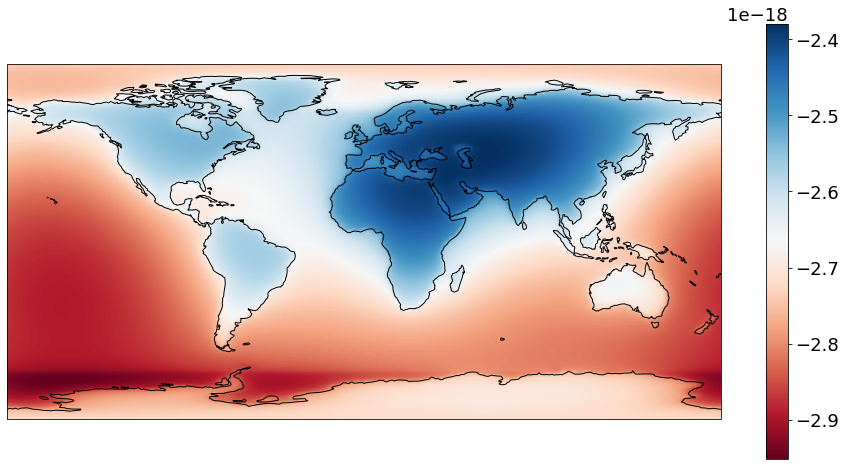

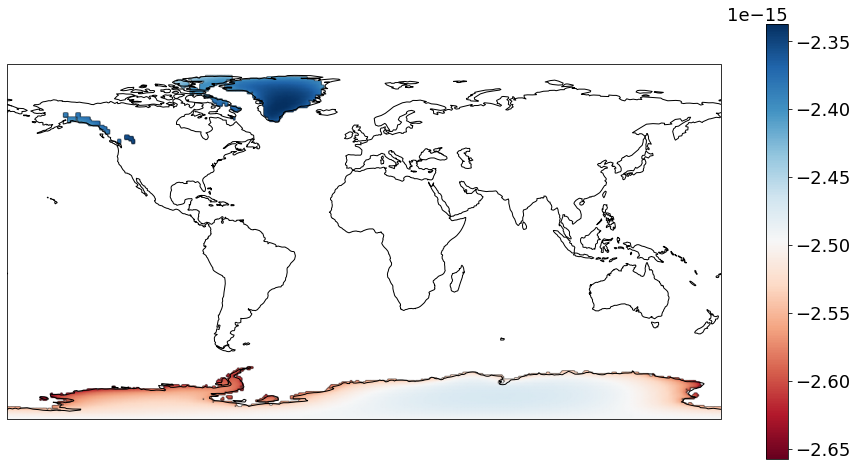

In [41]:
# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetry_load(sl0,ice0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)


# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d)

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K)
